# Text classification (multiclass)

### multi-class-text-classification-tfidf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


__Data__: Consumer complaints received about financial products and services<br>
__Data source:__ Public dataset downloaded from
https://catalog.data.gov/dataset/consumer-complaint-database

<a id='imp'></a>
## Importing packages and loading data

In [ ]:
# Input data files are available in the "../input/" directory.
import os
#print(os.listdir("../input"))

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# loading data
df = pd.read_csv('/content/drive/MyDrive/Dataset/complaints.csv')
df.shape

<ipython-input-3-cc662c847d1c>:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Dataset/complaints.csv')


(4091495, 18)

We have more than 1 million instances (rows) and 18 features (columns).

<a id='eda'></a>
## Exploratory Data Analysis (EDA) and Feature Engineering

In [ ]:
df.head(2).T # Columns are shown in rows for easy reading

,0,1
Date received,2023-08-24,2023-08-25
Product,"Credit reporting, credit repair services, or o...",Credit reporting or other personal consumer re...
Sub-product,Credit reporting,Credit reporting
Issue,Problem with a credit reporting company's inve...,Improper use of your report
Sub-issue,Was not notified of investigation status or re...,Reporting company used your report improperly
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,Experian Information Solutions Inc.,"SANTANDER HOLDINGS USA, INC."
State,NJ,FL
ZIP code,07024,33972


The dataset has features not needed for multi-classification. For text categorization, we'll create a new dataframe with ‘Product’ and ‘Consumer complaint narrative’ (renamed 'Consumer_complaint').

In [ ]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint']

df1.shape

(1482562, 2)

In [ ]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

Out of almost 1 million complaints, 380,000 have text (~30% of the dataset is not null). This number is still useful. Let's classify complaints by category.

In [ ]:
pd.DataFrame(df.Product.unique()).values

array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Credit reporting or other personal consumer reports'],
       ['Checking or savings account'],
       ['Credit card'],
       ['Debt collection'],
       ['Money transfer, virtual currency, or money service'],
       ['Student loan'],
       ['Credit card or prepaid card'],
       ['Mortgage'],
       ['Vehicle loan or lease'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Prepaid card'],
       ['Debt or credit management'],
       ['Payday loan, title loan, or personal loan'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Credit reporting'],
       ['Money transfers'],
       ['Payday loan'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

There are 18 target classes. Some classes are contained in others. The category ‘Credit card or prepaid card’ includes ‘Credit card’ and ‘Prepaid card’. Imagine we wish to classify a new credit card complaint. The computer can correctly categorise this complaint as 'Credit card' or 'Credit card or prepaid'. This would impact model performance. The names of several categories were changed to avoid this issue.

In [ ]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [ ]:
# Renaming categories
df2.replace({'Product':
             {'Credit reporting, credit repair services, or other personal consumer reports':
              'Credit reporting, repair, or other',
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}},
            inplace= True)

In [ ]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Debt collection
2,Checking or savings account
3,Mortgage
4,Vehicle loan or lease
5,Credit card or prepaid card
6,"Money transfer, virtual currency, or money ser..."
7,Consumer Loan
8,"Payday loan, title loan, or personal loan"
9,Student loan


In [ ]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
3285291,"Credit reporting, repair, or other",I have disputed the errors on my credit report...,0
661888,"Credit reporting, repair, or other",My house was broken into several years ago and...,0
2379215,"Credit reporting, repair, or other",In accordance with the fair credit reporting a...,0
154588,"Credit reporting, repair, or other",I sent a letter to TransUnion regarding a publ...,0
992576,"Credit reporting, repair, or other",My credit reports are inaccurate. These inaccu...,0


The bar chart below shows the number of complaints per category. It can be observed that The bar chart below shows the number of complaints per category. It can be observed that most of customer complaints are due to:
* credit reporting, credit repair
* debt collection
* mortgage

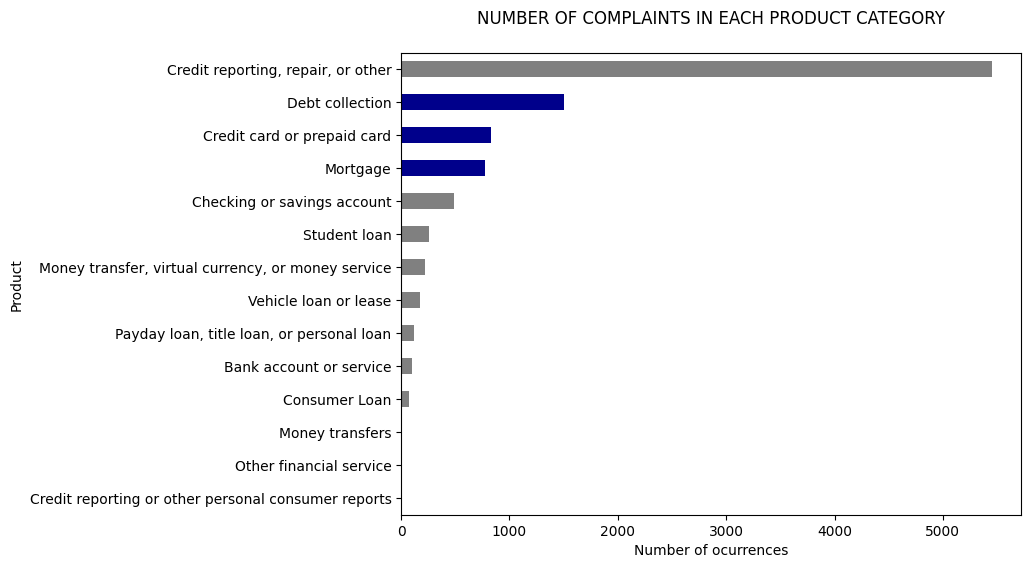

In [ ]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

<a id='pre'></a>
## Text Preprocessing

The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate __how important a word is to a document in a collection of documents__.

After removing __punctuation__ and __lower casing__ the words, importance of a word is determined in terms of its frequency.

### “Term Frequency – Inverse Document Frequency

__TF-IDF__ is the product of the __TF__ and __IDF__ scores of the term.<br><br> $$\text{TF-IDF}=\frac{\text{TF}}{\text{IDF}}$$<br>

__Term Frequency :__ This summarizes how often a given word appears within a document.

$$\text{TF} = \frac{\text{Number of times the term appears in the doc}}{\text{Total number of words in the doc}}$$<br><br>
__Inverse Document Frequency:__ This downscales words that appear a lot across documents. A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.<br>

$$\text{IDF} = \ln\left(\frac{\text{Number of docs}}{\text{Number docs the term appears in}} \right)$$<br>

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word _mortgage_ would be mentioned fairly often. However, if we look at other complaints, _mortgage_ probably would not show up in many of them. We can infer that _mortgage_ is most probably an important word in Mortgage complaints as compared to the other products. Therefore, _mortgage_ would have a high TF-IDF score for Mortgage complaints.

TfidfVectorizer class can be initialized with the following parameters:
* __min_df__: remove the words from the vocabulary which have occurred in less than ‘min_df’ number of files.
* __max_df__: remove the words from the vocabulary which have occurred in more than _‘max_df’ * total number of files in corpus_.
* __sublinear_tf__: set to True to scale the term frequency in logarithmic scale.
* __stop_words__: remove the predefined stop words in 'english'.
* __use_idf__: weight factor must use inverse document frequency.
* __ngram_range__: (1, 2) to indicate that unigrams and bigrams will be considered.

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26198 features (TF-IDF score of unigrams and bigrams)


In [ ]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Bank account or service:
  * Most Correlated Unigrams are: branch, citigold, overdraft
  * Most Correlated Bigrams are: personal banker, xxxx overdraft, overdraft fee

==> Checking or savings account:
  * Most Correlated Unigrams are: deposit, funds, checking
  * Most Correlated Bigrams are: debit card, savings account, checking account

==> Consumer Loan:
  * Most Correlated Unigrams are: repossessed, car, toyota
  * Most Correlated Bigrams are: corporation xxxx, purchased vehicle, repossessed car

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: merchant, citi, card
  * Most Correlated Bigrams are: card company, american express, credit card

==> Credit reporting or other personal consumer reports:
  * Most Correlated Unigrams are: turned, mis, carefully
  * Most Correlated Bigrams are: xxxx turned, turned credit, later 30

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: 1681, section, reporting
  * Most Correlated Bigrams are: reporti

<a id='ml'></a>
## Multi-Classification models

The classification models evaluated are:
* Random Forest
* Linear Support Vector Machine
* Multinomial Naive Bayes
* Logistic Regression.

<a id='sp'></a>
### Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [ ]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

<a id='m'></a>
### Models

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale 

<a id='sum'></a>
## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8227,0.003457
LogisticRegression,0.8073,0.006573
MultinomialNB,0.6811,0.000418
RandomForestClassifier,0.5453,0.000671


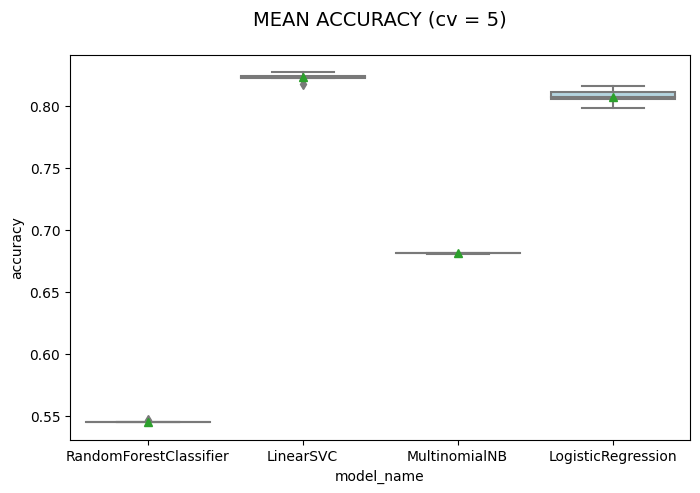

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

<a id='ev'></a>
## Model Evaluation

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.25,
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<a id='m'></a>
### Precision, Recall, F1-score

In [ ]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred))
#,target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1391
           1       0.72      0.74      0.73       347
           2       0.70      0.72      0.71       126
           3       0.85      0.91      0.88       189
           4       0.73      0.31      0.44        51
           5       0.70      0.77      0.73       185
           6       0.70      0.56      0.62        62
           7       0.00      0.00      0.00        23
           8       0.25      0.08      0.12        26
           9       0.91      0.69      0.78        70
          10       0.67      0.07      0.12        29
          11       0.00      0.00      0.00         1

    accuracy                           0.82      2500
   macro avg       0.59      0.48      0.50      2500
weighted avg       0.81      0.82      0.81      2500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It is possible to observe that the classes with more support (number of occurrences) tend to have a better f1-cscore. This is because the algorithm was trained with more data.<br><br>
The classes that can be classified with more precision are __‘Mortgage’__, __‘Credit reporting, repair, or other’__, and __‘Student loan’__.

<a id='cm'></a>
### Confusion Matrix

A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.<br><br>
If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

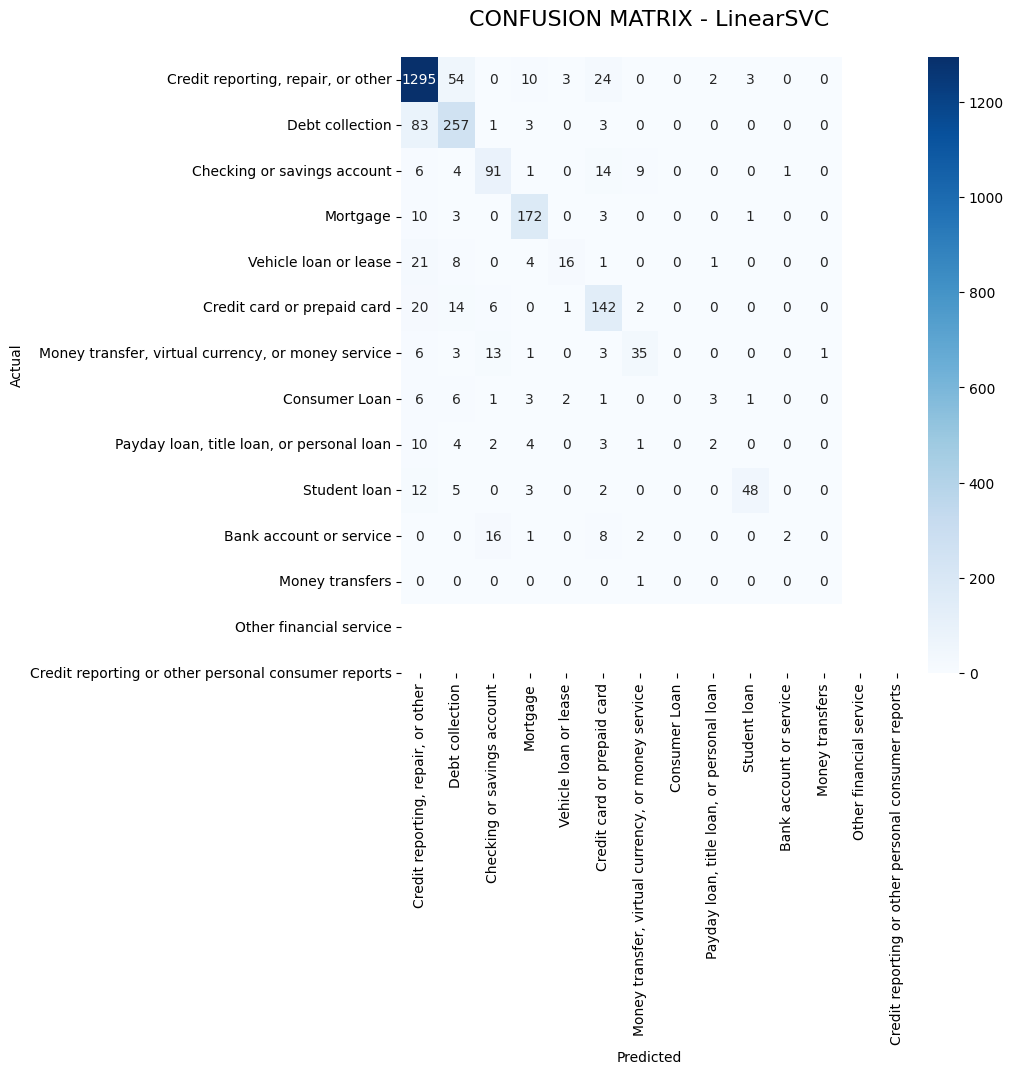

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In general, the confusion matrix looks good (clear diagonal that represents correct classifications). Nevertheless, there are cases were the complaint was classified in a wrong class.

#### Misclassified complaints
Let’s have a look at the cases that were wrongly classified.

In [ ]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat[actual, predicted]))

      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product',
                                                                'Consumer_complaint']])
      print('')

'Debt collection' predicted as 'Credit reporting, repair, or other' : 83 examples.


,Product,Consumer_complaint
552490,Debt collection,I don't have any accounts with this company an...
623438,Debt collection,i called the company and tried to report fraud...
1497187,Debt collection,"I, the consumer did not authorize or give any ..."
2684933,Debt collection,My personal information was shared with someon...
1473077,Debt collection,I sent letters to Equifax Credit Bureau on the...
...,...,...
147080,Debt collection,I did not give prior written consent to have a...
445848,Debt collection,I transferred my cell phone service away from ...
4042531,Debt collection,I keep getting this information reported on th...
3924450,Debt collection,"XX/XX/XXXX XXXX XXXX XXXX XXXX XXXX XXXX, FL X..."



'Vehicle loan or lease' predicted as 'Credit reporting, repair, or other' : 21 examples.


,Product,Consumer_complaint
177975,Vehicle loan or lease,I am XXXX XXXX XXXX and I am submitting this c...
3881453,Vehicle loan or lease,"XXXX, XXXX, XXXX of XXXX is missing payment in..."
1584857,Vehicle loan or lease,ally financial is reporting my vehicle payment...
3380448,Vehicle loan or lease,Not only did they add fees such as GAP ins and...
791874,Vehicle loan or lease,Account Name : Flagship Credit Accept XXXX I w...
907323,Vehicle loan or lease,I leased a XXXX XXXX XXXX on XX/XX/XXXX throug...
563472,Vehicle loan or lease,Amidst this worldwide crisis that we are facin...
350240,Vehicle loan or lease,I received a copy of the condition report and ...
1032239,Vehicle loan or lease,This is a follow up to case # XXXX. I was not ...
2335275,Vehicle loan or lease,I was looking through my report and noticed a ...



'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 20 examples.


,Product,Consumer_complaint
697765,Credit card or prepaid card,"I am the consumer, original creditor and natur..."
796035,Credit card or prepaid card,My credit card information was used to charge ...
1530900,Credit card or prepaid card,There was an account opened up around XX/XX/20...
90919,Credit card or prepaid card,This just proves your lack of proper record ke...
381558,Credit card or prepaid card,I have a loan with CONNS. I have always made m...
1921764,Credit card or prepaid card,I checked my credit score which went down arou...
1327637,Credit card or prepaid card,I have contacted Zales/Comenity Bank several t...
4015253,Credit card or prepaid card,Citibank sent XXXX checks for {$29000.00} to a...
429324,Credit card or prepaid card,This account is being reported inaccurately. I...
3659976,Credit card or prepaid card,Due to coronavirus I was laid-off from my job ...


IndexError: ignored

#### Most correlated terms with each category

In [ ]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Bank account or service':
  * Top unigrams: miles, 2016, bank, overdraft
  * Top bigrams: account reason, hold account, account bank, personal banker

==> 'Checking or savings account':
  * Top unigrams: bank, chime, checking, funds
  * Top bigrams: checking account, debit card, account frozen, close account

==> 'Consumer Loan':
  * Top unigrams: toyota, excessive, chrysler, financed
  * Top bigrams: repossessed car, family members, xxxx creditors, taking money

==> 'Credit card or prepaid card':
  * Top unigrams: card, citi, barclays, cards
  * Top bigrams: xxxx accounts, card company, late fee, received money

==> 'Credit reporting or other personal consumer reports':
  * Top unigrams: carefully, mis, notify, responsibility
  * Top bigrams: later 30, turned credit, xxxx turned, reporting information

==> 'Credit reporting, repair, or other':
  * Top unigrams: experian, equifax, transunion, report
  * Top bigrams: xxxx xxxx, xxxx reported, xxxx transunion, balance owed

==> 'De

<a id='pred'></a>
## Predictions

Now let's make a few predictions on unseen data.<br>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

Let's see what is the classification that our model gives to this new complaint.

In [ ]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


The algorithm has classified this text as a "Student loan" complaint. Now let's look at the real label of this complaint.

In [ ]:
df2[df2['Consumer_complaint'] == new_complaint]

,Product,Consumer_complaint,category_id


Our model was correct, the complaint was about **Student Loan**. Note that this customer has used terms with high TFIDF score, such us **Navient[](http://)**.<br><br>
Let's check another example.

In [ ]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']


In [ ]:
df2[df2['Consumer_complaint'] == new_complaint_2]

,Product,Consumer_complaint,category_id


Again, the algorithm correctly classified the caomplaint as __"Credit reporting, repair, or other"__. Note that this customer has used terms with high TFIDF score, such us __equifax, report__. <br><br>
Although our model is not going to be all the time correct when classifying new complaints, it does a good job.